This notebook is structured from a [blog post written by Saugata Paul](https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674) with a bunch of edits made by Matthew Kehoe.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Importing all the neccessary libraries
#%matplotlib inline
import sqlite3, pandas as pd, numpy as np, nltk, string, matplotlib.pyplot as plt, seaborn as sns
import string, math, pickle
import warnings
warnings.filterwarnings("ignore")
from xgboost.sklearn import XGBModel, XGBRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import datasets

This notebook will provide an <font color='blue'>intuitive understanding</font> of how <font color='blue'>ensemble models</font> in Machine Learning work. We will take a look at some of the most common ensemble learning strategies which are deployed by thousands of Kagglers and dive deeper into making more accurate predictions using a particular ensemble strategy called <font color='blue'>Stacking Classifiers</font>.

<font color='blue'>Ensemble learning</font> is a strategy in which <font color='blue'>multiple models</font> are <font color='blue'>used in conjugation</font> to <font color='blue'>solve</font> a particular <font color='blue'>computational problem</font>. Ensemble methods strategically <font color='blue'>combine diverse</font> machine learning <font color='blue'>models</font> into one <font color='blue'>single predictive model</font>. In most of the cases, ensemble methods are primarily used to <font color='blue'>improve</font> the <font color='blue'>overall performance</font> of a model. Instead of using any one model to solve a problem, what ensemble models do is that it combine several different models to predict the results of a final model. More often than not, ensemble models are used to improve the performance accuracy of a model. The <font color='blue'>more different</font> these models are, the <font color='blue'>more powerful</font> will the final model be. In any machine learning model, the <font color='blue'>generalization error</font> is given by the <font color='blue'>sum of squares of bias + variance + irreducible error</font>. Irreducible errors are something that is beyond our control. We cannot reduce them. However <font color='blue'>using ensemble techniques</font> we can <font color='blue'>reduce</font> the <font color='blue'>bias and variance</font> of a <font color='blue'>model</font> to an extent, as well as <font color='blue'>improve</font> the <font color='blue'>prediction accuracy</font> of the final model. This <font color='blue'>reduces</font> the <font color='blue'>overall generalization error</font>. Using <font color='blue'>several models</font> to predict one outcome <font color='blue'>reduces</font> the <font color='blue'>likelihood</font> of a forlorn <font color='blue'>selection</font> of an <font color='blue'>inferior model</font>. The <font color='blue'>bias-variance trade-off</font> is the <font color='blue'>most important benchmark</font> that differentiates a robust model from an inferior one. In machine learning, the <font color='blue'>models</font> which have a <font color='blue'>high bias</font> tends to have a <font color='blue'>lower variance</font> and vice-versa.  

1. <font color='blue'>Bias</font> is an <font color='blue'>error</font> which arises due to <font color='blue'>incorrect assumptions</font> in the <font color='blue'>learning algorithm</font>, which is the backbone of any machine learning model. A <font color='blue'>high bias</font> can cause a machine learning algorithm to <font color='blue'>skip relevant information</font> and <font color='blue'>miss important correlations</font> between the independent variables and the class labels, thereby <font color='blue'>underfitting</font> the model.

2. The <font color='blue'>variance</font> in a model means <font color='blue'>how sensitive</font> the model is to <font color='blue'>small fluctuations</font> in the <font color='blue'>training data</font>. That is by how much the model changes with small changes in the training samples. <font color='blue'>High variance</font> in a machine learning algorithm will make the <font color='blue'>model prone</font> to <font color='blue'>random noise</font> present in the dataset thereby <font color='blue'>overfitting</font> the model.  

![](https://media.geeksforgeeks.org/wp-content/uploads/20200107023418/1_oO0KYF7Z84nePqfsJ9E0WQ.png)

Think of ensemble learning analogous to the board of directors in a company, where the final decision is taken by the CEO. Instead of taking a decision all by himself, the CEO takes inputs from each of the board members before arriving at a final conclusion. The CEO, in this case, is the final model and the board members are the several models which provide different inputs to the CEO in order for him to arrive at a conclusion. This drastically reduces the chance of committing an error when the CEO makes his final decision. We use this approach regularly in our daily lives as well -  for example, we ask for the opinions of several different experts before arriving at a conclusion, we generally consult several doctors before agreeing to particular medical procedure, we read so many reviews written by different customers before setting our mind to buy a particular product. In each of the above scenarios what we are actually trying to achieve is to minimize the likelihood of an unfortunate decision made by one person (in our case a poor model).  

Typically, <font color='blue'>ensemble learning</font> can be categorized into <font color='blue'>four categories</font>:

1. <font color='blue'>Bagging</font>: Bagging is mostly used to <font color='blue'>reduce</font> the <font color='blue'>variance</font> in a model. An example of bagging is the <font color='blue'>Random Forest</font> algorithm.

2. <font color='blue'>Boosting</font>: Boosting is mostly used to <font color='blue'>reduce</font> the <font color='blue'>bias</font> in a model. Examples of boosting algorithms are <font color='blue'>Ada-Boost, XGBoost, Gradient Boosted Decision Trees, etc.</font>

3. <font color='blue'>Stacking</font>: Stacking is mostly used to <font color='blue'>increase</font> the <font color='blue'>prediction accuracy</font> of a model. For implementing stacking we will use the <font color='blue'>mlextend library</font> provided by <font color='blue'>scikit-learn</font>.

4. <font color='blue'>Cascading</font>: These class of models are <font color='blue'>very accurate</font>. Cascading is mostly used in <font color='blue'>scenarios</font> where you <font color='blue'>cannot afford a mistake</font>. For example, a cascading technique is mostly used to <font color='blue'>detect fraudulent credit card transactions</font>, or maybe when you want to be absolutely sure that you don't have <font color='blue'>cancer</font>.

In this article, we will mostly explain the ensemble learning strategies called Bagging, Boosting and Stacking with some code samples. We will also try to give an intuitive understanding of what cascading means and for what purpose should we use it. We will work with the <font color='blue'>Iris dataset</font> mainly because of its simplicity. You can try all these techniques and apply them to any real-world dataset you want. However, the performance will vary across datasets of different types. The Iris dataset can be downloaded from https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv. For those of you who aren't aware of what Iris database is, it's basically a dataset which contains information about <font color='blue'>three species of flowers</font> - <font color='blue'>setosa, versiclor, and virginica</font>. The <font color='blue'>four features</font> that distinguish these flowers are <font color='blue'>petal length, septal length, petal width,</font> and <font color='blue'>sepal width</font>. The main aim of a <font color='blue'>classification model</font> is to learn the <font color='blue'>relationships between</font> the <font color='blue'>features</font> and the </font>class label</font> and thereby classifying the three species of flowers.

The first thing that we are going to do is draw the <font color='blue'>pair plots</font> for all the <font color='blue'>independent variables</font> in the Iris dataset. In this way, we can visually see how each of the features helps to classify the data with respect to one another.

### Load Iris dataset + pair plots.

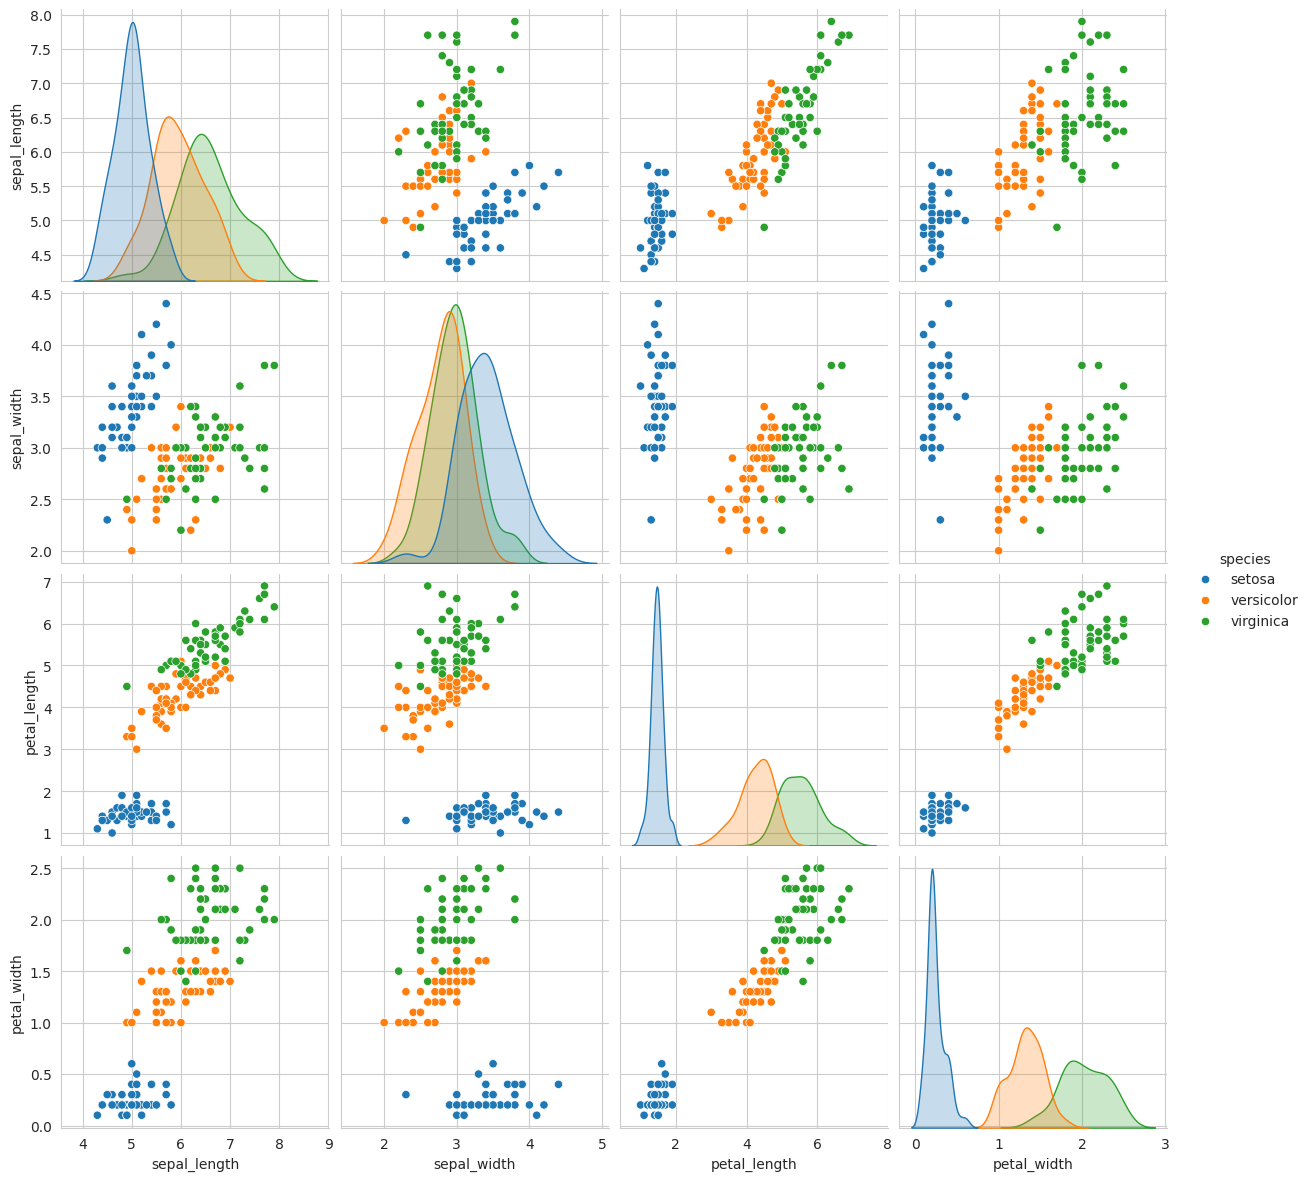

In [3]:
#Load Iris.csv into a pandas dataFrame.
iris_dataset = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

#Pair plots for iris dataset
import seaborn as sns
plt.close();
sns.set_style("whitegrid");
sns.pairplot(iris_dataset, hue="species", size=3);
plt.show()

From the pair plots above, we can see that <font color='blue'>petal length</font> and <font color='blue'>petal width</font> are the <font color='blue'>two most important features</font> that <font color='blue'>visually separates</font> the <font color='blue'>three classes of flower</font> most accurately. We can visually differentiate them through looking at the pair plots. We don't even need machine learning models to predict the class labels. Now let's build a model and try out different classifiers and different ensemble techniques to find out how they behave on the Iris dataset.

### Bagging.

The first ensemble technique that we will discuss is <font color='blue'>Bagging</font>. Bagging stands for <font color='blue'>bootstrap aggregation</font>. It's a very very interesting idea in ensemble learning! Bagging is one of the <font color='blue'>earliest yet powerful ensemble algorithm</font> that exists even today. The <font color='blue'>core idea</font> of bagging is to use <font color='blue'>bootstrapped replicas</font> of the <font color='blue'>original dataset</font> and use them to <font color='blue'>train different classifiers</font>. Suppose we are given a dataset, we will <font color='blue'>create subsets</font> by <font color='blue'>randomly sampling</font> a bunch of <font color='blue'>points</font> from the <font color='blue'>original data</font>, with replacement. Now we will <font color='blue'>train individual classifiers</font> on <font color='blue'>each</font> of these <font color='blue'>bootstrapped subsets</font>. Each of these <font color='blue'>base classifiers</font> will <font color='blue'>predict</font> the <font color='blue'>class label</font> for a <font color='blue'>given problem</font>. This is where we <font color='blue'>combine</font> the <font color='blue'>predictions</font> of <font color='blue'>all</font> the <font color='blue'>base models</font>. This part is called the <font color='blue'>aggregation stage</font>. Typically a simple <font color='blue'>majority vote</font> is used in a <font color='blue'>classification system</font> and taking the <font color='blue'>mean</font> of <font color='blue'>all predictions</font> for regression models, to combine all the base classifiers into one single model to provide the final output of the ensemble model. A typical example of such an approach is the <font color='blue'>Random Forest</font> algorithm. Bagging <font color='blue'>reduces</font> the <font color='blue'>high variance</font> of a model while keeping the bias constant, thereby <font color='blue'>reducing</font> the <font color='blue'>generalization error</font>. Bagging is a very efficient method especially when you have <font color='blue'>very limited data</font>. By using bootstrapped samples we are able to get an estimate by aggregating the scores over many samples. Please take a look at the below diagrams to get an intuitive understanding of how bagging works at different stages.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*X95SV4OlhtD-_8doaSuw8w.png)

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*JksRZ1E72Rsx2s8lQbNR1w.jpeg)

Let us understand the above diagram with the help of an example. Let's say we have a <font color='blue'>training dataset</font> which contains <font color='blue'>100,000 data points</font>. We will create <font color='blue'>N subsets</font> by <font color='blue'>randomly sampling 50,000 data points</font> for <font color='blue'>each subset</font>. So we have a <font color='blue'>total</font> of <font color='blue'>N datasets</font> now. Each of these N datasets will be used to <font color='blue'>train N different classifiers</font>. At the <font color='blue'>aggregation stage</font>, all these <font color='blue'>N predictions</font> will be <font color='blue'>combined</font> into one <font color='blue'>single model</font> also called the <font color='blue'>meta-classifier</font>. Out of the <font color='blue'>100,000 points present</font> originally present in the dataset, if we <font color='blue'>remove 1000 points</font>, the impact it will have on the <font color='blue'>sampled datasets</font> will be <font color='blue'>small</font>. If you think <font color='blue'>intuitively</font>, some of these 1000 points might <font color='blue'>not be present</font> in <font color='blue'>all the sampled datasets</font> at all and thus the number of points that will be removed from each sampled dataset will be small. It could even be zero in some cases. Thus, by using the bootstrap aggregation strategy, the <font color='blue'>impact</font> of <font color='blue'>removing 1000 points</font> from the <font color='blue'>original training set</font> will be <font color='blue'>small</font> on the <font color='blue'>sampled datasets</font>. To sum it up, the impact of removing 1000 such points will be small on the base learners, thereby <font color='blue'>reducing the variance</font> in a model and making it more robust. Variance is nothing but sensitivity to noise as we have discussed earlier.  

In the code sample below, first, what we do is <font color='blue'>initialize 8 different base learners</font>. We will <font color='blue'>fit</font> each of these <font color='blue'>8 base learners</font> to our <font color='blue'>training set</font> and <font color='blue'>compare it's accuracy</font> to the bagging versions of each of the classifiers. In most of the cases below, we see that there is a <font color='blue'>slight increase</font> in the <font color='blue'>model's accuracy</font> when we use the <font color='blue'>bagging version</font> of each classifier as compared to the normal ones. For this classification task, we will use a <font color='blue'>3 fold cross-validation</font> to obtain the accuracy scores across different folds. You can increase the number of folds if you have a large real-world training set. For each of the base learners selected below, we see that bagging actually works! Using bagging has actually improved the accuracy by a certain margin (most notably in the AdaBoostClassifier).

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

iris_dataset = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

RANDOM_SEED = 0

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
rg_clf = RidgeClassifier(alpha=0.1, random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=RANDOM_SEED)
adab_clf = AdaBoostClassifier(n_estimators=5,learning_rate=0.001)

classifier_array = [rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]

normal_accuracy = []
normal_std = []

bagging_accuracy = []
bagging_std = []

for clf in classifier_array:
    cv_scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=RANDOM_SEED)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=3, n_jobs=-1)

    normal_accuracy.append(np.round(cv_scores.mean(),4))
    normal_std.append(np.round(cv_scores.std(),4))

    bagging_accuracy.append(np.round(bagging_scores.mean(),4))
    bagging_std.append(np.round(bagging_scores.std(),4))

    print("Accuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))
    print("Accuracy: %0.4f (+/- %0.4f) [Bagging %s]\n" % (bagging_scores.mean(), bagging_scores.std(), clf.__class__.__name__))

Accuracy: 0.9667 (+/- 0.0189) [Normal RandomForestClassifier]
Accuracy: 0.9667 (+/- 0.0189) [Bagging RandomForestClassifier]

Accuracy: 0.9533 (+/- 0.0094) [Normal ExtraTreesClassifier]
Accuracy: 0.9533 (+/- 0.0249) [Bagging ExtraTreesClassifier]

Accuracy: 0.9467 (+/- 0.0094) [Normal KNeighborsClassifier]
Accuracy: 0.9867 (+/- 0.0094) [Bagging KNeighborsClassifier]

Accuracy: 0.9600 (+/- 0.0163) [Normal SVC]
Accuracy: 0.9733 (+/- 0.0189) [Bagging SVC]

Accuracy: 0.7933 (+/- 0.0340) [Normal RidgeClassifier]
Accuracy: 0.8200 (+/- 0.0432) [Bagging RidgeClassifier]

Accuracy: 0.9733 (+/- 0.0189) [Normal LogisticRegression]
Accuracy: 0.9800 (+/- 0.0163) [Bagging LogisticRegression]

Accuracy: 0.9333 (+/- 0.0189) [Normal DecisionTreeClassifier]
Accuracy: 0.9533 (+/- 0.0249) [Bagging DecisionTreeClassifier]

Accuracy: 0.6600 (+/- 0.0000) [Normal AdaBoostClassifier]
Accuracy: 0.9600 (+/- 0.0163) [Bagging AdaBoostClassifier]



Here, in the <font color='blue'>below code sample</font> what we do is <font color='blue'>visually see</font> how the <font color='blue'>accuracy improves</font> on using a <font color='blue'>bagging classifier</font> as compared to a normal one. The <font color='blue'>black line</font> present at the top of each bar indicates the <font color='blue'>variance</font> in the model. As we can see, the <font color='blue'>variance mostly reduces</font> when we use the <font color='blue'>bagging version</font> of any classifier. However, for <font color='blue'>some models</font>, we also have a situation where the <font color='blue'>variance increases slightly</font> more than the normal version of the classifier. This is mostly because of a lack of training data points. Remember we have only 150 observations in our training dataset. Greater the number of data points in our train set, more robust will the final models be. However, from a simple implementation point of view, this code sample helps us understand how to <font color='blue'>implement</font> the concept of <font color='blue'>bootstrap aggregation</font>.

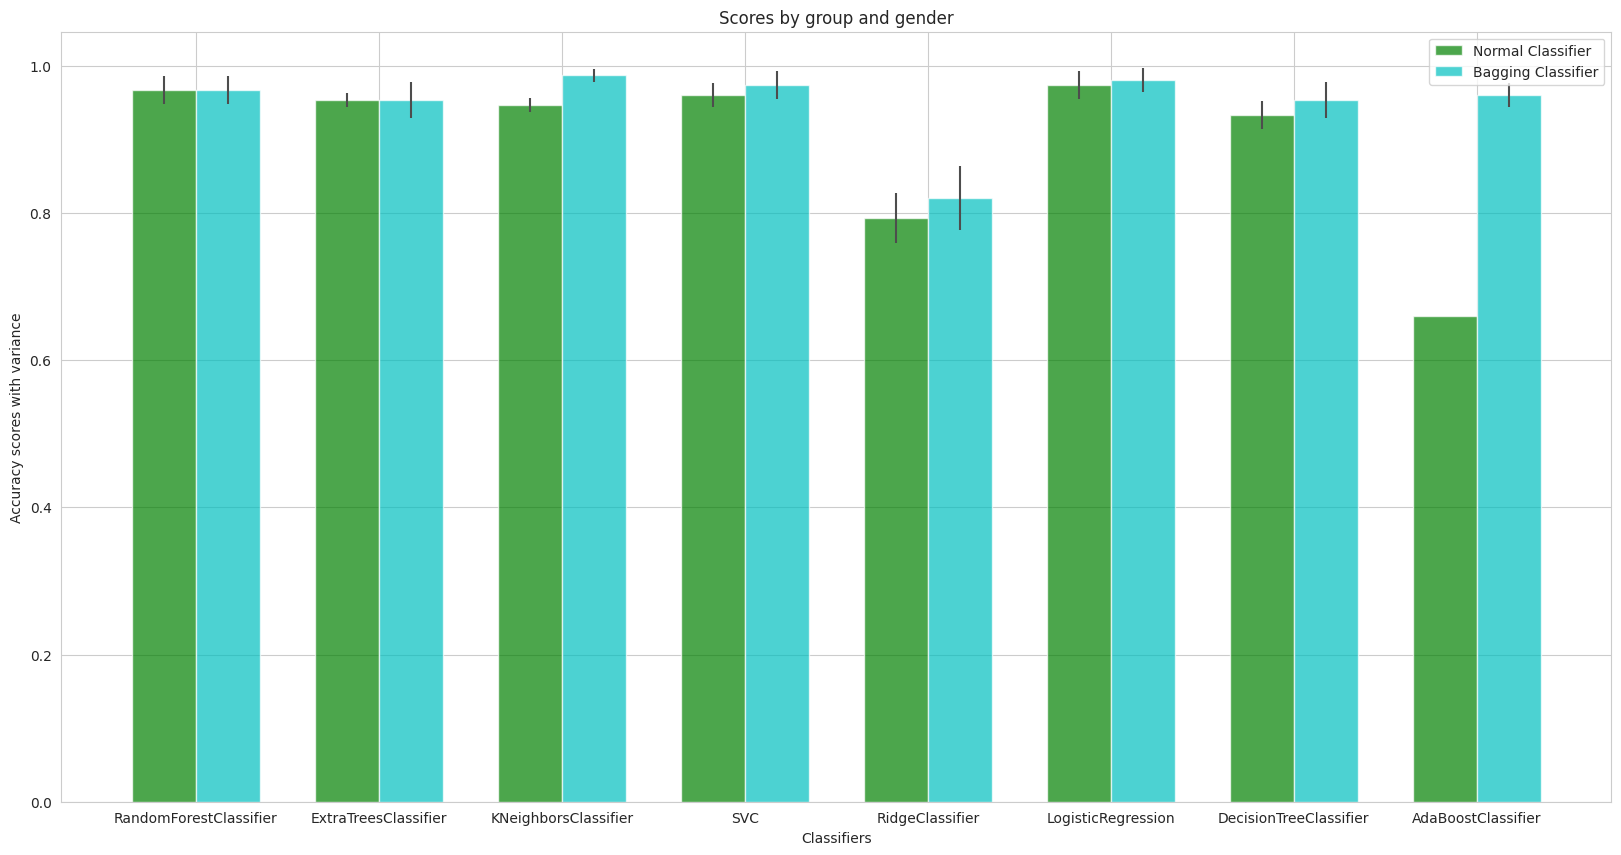

In [5]:
### Bagging.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 8
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

normal_clf = ax.bar(index, normal_accuracy, bar_width, alpha=opacity, color='g', yerr=normal_std, error_kw=error_config, label='Normal Classifier')
bagging_clf = ax.bar(index + bar_width, bagging_accuracy, bar_width, alpha=opacity, color='c', yerr=bagging_std, error_kw=error_config, label='Bagging Classifier')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores with variance')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

#fig.tight_layout()

plt.show()

### Impact of change in bagging accuracies with an increase in the sub-sampling ratio.

A very <font color='blue'>important factor</font> to be kept in mind while building <font color='blue'>bagging classifiers</font> is that the <font color='blue'>accuracy</font> of a model doesn't always increase when we <font color='blue'>increase the sub-sampling ratio</font>. In the Bagging Classifier library, <font color='blue'>subsampling</font>, i.e. the fraction of data that gets into each of the base learners, is denoted by the parameter <font color='blue'>max_samples</font>. In the code sample below, we will see the display the <font color='blue'>bagging scores</font> for each of the base learners at <font color='blue'>various subsampling ratio</font>. We will also plot the bagging scores for each of the base learners in a line chart to get a more intuitive understanding of this concept - that is bagging scores doesn't necessarily increase when we increase the sub-sampling ratio.

In [6]:
### Display the accuracy of different bagging classifiers at various sub sampling ratio in a Pretty table.

subsampling_ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

various_bagging_scores = []

for clf in classifier_array:
    cv_scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)
    #print("\nAccuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))

    mean_bagging_score = []
    for ratio in subsampling_ratio:
        bagging_clf = BaggingClassifier(clf, max_samples=ratio, max_features=3, random_state=RANDOM_SEED)
        bagging_scores = cross_val_score(bagging_clf, X, y, cv=3, n_jobs=-1)
        mean_bagging_score.append(bagging_scores.mean())
        #print("Bagging accuracy: %0.4f [max_samples %0.2f]" % (bagging_scores.mean(), ratio))
    various_bagging_scores.append(mean_bagging_score)

various_bagging_scores.insert(0,subsampling_ratio)

#Compare performance and display it in a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
labels.insert(0,"Max Samples")
#table.field_names = label_models

index=0

for value in various_bagging_scores:
    table.add_column(labels[index],value)
    index += 1
print(table)

+-------------+------------------------+----------------------+----------------------+--------------------+--------------------+--------------------+------------------------+--------------------+
| Max Samples | RandomForestClassifier | ExtraTreesClassifier | KNeighborsClassifier |        SVC         |  RidgeClassifier   | LogisticRegression | DecisionTreeClassifier | AdaBoostClassifier |
+-------------+------------------------+----------------------+----------------------+--------------------+--------------------+--------------------+------------------------+--------------------+
|     0.1     |   0.9466666666666667   |  0.9466666666666667  |  0.9666666666666667  | 0.9666666666666667 | 0.8266666666666667 |        0.96        |          0.94          | 0.9266666666666666 |
|     0.2     |   0.9533333333333333   |  0.9666666666666667  |  0.9733333333333333  | 0.9666666666666667 | 0.7933333333333333 | 0.9733333333333333 |          0.94          | 0.9466666666666667 |
|     0.3     |     

This code sample helps us understand that the <font color='blue'>bagging accuracy doesn't always increase</font> when we <font color='blue'>increase the sub-sampling ratio</font>. In the plot below, we can clearly see for <font color='blue'>AdaBoost classifier</font> (denoted by the <font color='blue'>maroon</font> line), that the bagging accuracy drops to a significantly lower value when we increase the <font color='blue'>sampling ration from 0.7 to 0.8</font>. For the Decision Tree classifier, the bagging accuracy falls beyond the sampling ratio of 0.4. This behavior is almost the same for all the different base learners. There is absolutely no evidence of the fact that a higher sub-sampling ratio means a higher bagging accuracy. I have taken my sampling ratio to be 0.4. You can try and experiment with different values on a different dataset and see if you find any correlation between the sub-sampling ratio and the bagging accuracy.

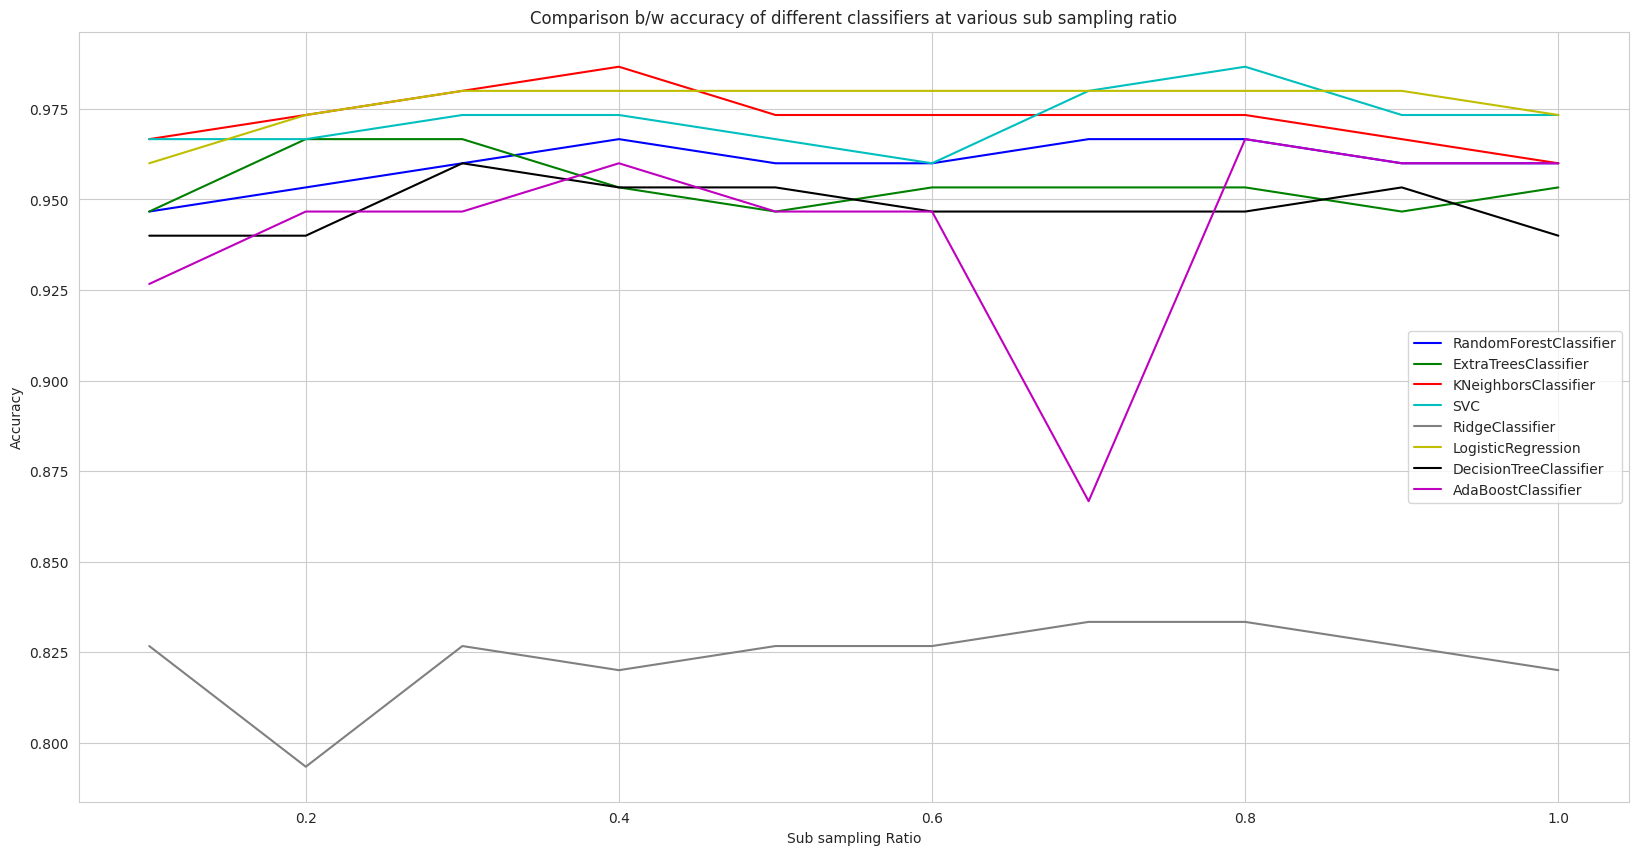

In [7]:
#Plot the bagging scores using a line chart.
labels.remove("Max Samples")
various_bagging_scores.remove(various_bagging_scores[0])

x_axes = subsampling_ratio

color_map = ['blue','g','r','c','grey','y','black','m']
plt.figure(figsize=(20,10))
for index in range(0,len(labels)):
    plt.plot(x_axes, various_bagging_scores[index], color=color_map[index], label=labels[index])
plt.xlabel('Sub sampling Ratio')
plt.ylabel('Accuracy')
plt.title("Comparison b/w accuracy of different classifiers at various sub sampling ratio")
plt.legend()
plt.show()

### Boosting:

The second ensemble technique that we are going to review is known as <font color='blue'>Boosting</font>. Boosting, in general, is used to <font color='blue'>convert weak learners</font> to <font color='blue'>strong ones</font>. <font color='blue'>Weak learners</font> are basically <font color='blue'>classifiers</font> which have a <font color='blue'>very weak correlation</font> with the <font color='blue'>true class labels</font> and <font color='blue'>strong learners</font> are classifiers that have a very <font color='blue'>high correlation</font> between the model and the <font color='blue'>true class labels</font>. Boosting involves training the weak learners <font color='blue'>iteratively</font>, each trying to correct the error made by the previous model. This is achieved by <font color='blue'>training</font> a <font color='blue'>weak model</font> on the <font color='blue'>whole training data</font>, then <font color='blue'>building</font> a <font color='blue'>second model</font> which aims at <font color='blue'>correcting the errors</font> made by the first model. Then we build a third model which will correct the errors made by the second model and so on. Models are <font color='blue'>added iteratively</font> until the final model has corrected all the errors made by all the previous models. When the models are added at each stage, some <font color='blue'>weights</font> are assigned to the model which is related to the <font color='blue'>accuracy</font> of the <font color='blue'>previous model</font>. After a <font color='blue'>weak classifier</font> is <font color='blue'>added</font>, the <font color='blue'>weights</font> are <font color='blue'>re-adjusted</font>. The <font color='blue'>misclassified points</font> are given a <font color='blue'>higher weight</font> and correctly classified points are assigned lower weights. Such an approach will make the <font color='blue'>next weak classifier</font> to focus on the <font color='blue'>errors</font> made by the <font color='blue'>previous model</font>. Boosting <font color='blue'>reduces generalization error</font> by taking a high-bias & low-variance model and <font color='blue'>reducing the bias</font> by a significant level. Remember, <font color='blue'>bagging reduces variance</font>. Similar to bagging, boosting also lets us work with both classification and regression models. Please take a look at the below diagram to intuitively understand how boosting works at each of the stages. The diagram below shows the different stages in a boosting algorithm.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*6SMPOnlfr0alGyCNVch1xg.jpeg)

Let's understand the above diagram with an example. Suppose we are given a <font color='blue'>dataset $D$</font>, the <font color='blue'>first thing</font> that we will do at <font color='blue'>stage 0</font> is <font color='blue'>train a model</font> on the <font color='blue'>whole dataset</font>. The model may be <font color='blue'>either</font> a <font color='blue'>classification</font> or a <font color='blue'>regression</font> model. Let's name this model <font color='blue'>$M_0$</font>. Let us assume this model $M_0$ is trying to <font color='blue'>fit</font> a <font color='blue'>function $h_0(x)$</font>. Thus the <font color='blue'>prediction function</font> for this model is given by

$$y_{\text{pred}}=h_0(x).$$

<font color='blue'>Model 0</font> is designed to have a <font color='blue'>high bias</font>. Generally <font color='blue'>boosting</font> is applied for a <font color='blue'>high bias and low variance model</font>. High bias in a model basically refers to a <font color='blue'>high training error</font>. High bias arises mostly due to some <font color='blue'>incorrect assumptions</font> made at the training stage. Now, after building the first model we will, at stage $0$, get the error in prediction for each data points made by the model $M_0$. So, the error in the prediction for any class label is given by

$$\text{error}=y-y_{\text{pred}}.$$

Remember, there are lots of lots of error functions out there - the squared error, the hinge loss error, the logistic loss error, etc. But, for simplicity, we have taken a <font color='blue'>difference error</font> for this example. Now that we have done these things in stage $0$, what we will do in stage 1 is as follows. We will try to <font color='blue'>fit</font> a <font color='blue'>model $M_1$</font> on the e<font color='blue'>errors</font> produced by the model at stage $0$. Remember, $M_1$ is <font color='blue'>not training</font> on the <font color='blue'>actual class labels</font>. $M_1$ is training on the <font color='blue'>errors</font> we have got at the <font color='blue'>end of stage $0$</font>. Let's say we get a function $h_1(x)$, which has trained on the errors generated by model $M_0$. Thus at <font color='blue'>end of stage $1$</font>, our final model will actually be the <font color='blue'>weighted sum</font> of the <font color='blue'>previous two prediction functions</font> (as shown in the diagram). We will assign weights $a_0$ and $a_1$ to $h_0(x)$ and $h_1(x)$ respectively. Thus at the end of stage 1, the model looks like this :

$$F_1(x) = a_0 \cdot h_0(x) + a_1 \cdot h_1(x),$$

where $a_0$ and $a_1$ are <font color='blue'>weights</font> assigned to the <font color='blue'>prediction functions</font>. Remember, the weights will always be <font color='blue'>higher</font> for functions which have a <font color='blue'>high misclassification error</font>. In this way, we can make the next model in the sequence to focus more on the errors made by the previous model. Similarly, the model at the end of stage 2 will have the function

$$F_2(x) = a_0 \cdot h_0(x) + a_1 \cdot h_1(x) + a_2 \cdot h_2(x).$$

Thus at the end of all stages, the <font color='blue'>final model</font> that we have is given by <font color='blue'>summation of $a_i * h_x(i)$</font>, where the value of $i$ ranges from $1$ to $N$. Thus, intuitively if we think we are actually reducing the training error which means in other words we are actually reducing the bias of a model. The diagram below shows the the pseudo code for the boosting algorithm.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*O_HnrkpxyOm7SvlDzFMstQ.png)

We will look at some of the <font color='blue'>most popular boosting classifiers</font> in the below code sample. We will also see how using boosting <font color='blue'>increases</font> the <font color='blue'>overall accuracy</font> in prediction using an <font color='blue'>EnsembleVoteClassifier</font>. EnsembleVoteClassifier is a very powerful class available in the <font color='blue'>MLEXTEND package</font>, which is used to <font color='blue'>combine</font> the <font color='blue'>predictions</font> of different machine learning models by using the concept of <font color='blue'>majority voting</font>. The EnsembleVoteClassifier implements <font color='blue'>two types</font> of voting approach - <font color='blue'>hard</font> and <font color='blue'>soft</font>. In a <font color='blue'>hard voting approach</font> we will predict the <font color='blue'>class label</font> of the final model based on the <font color='blue'>majority vote</font> obtained from <font color='blue'>all</font> the <font color='blue'>base classifiers</font>. For example, if <font color='blue'>7 out of 10</font> base learners predicts the class label to be <font color='blue'>Yes</font> in a binary classification problem, we will take Yes to be the <font color='blue'>final class label</font> of the final ensemble model. In the below example we see that the accuracy increases to 0.967 (when we use boosted classifiers with majority voting) as compared to the highest accuracy of an individual model which was 0.961.

In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

ada_boost = AdaBoostClassifier(n_estimators=5)
grad_boost = GradientBoostingClassifier(n_estimators=10)
xgb_boost = XGBClassifier(max_depth=5, learning_rate=0.001)

ensemble_clf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
boosting_labels = ['Ada Boost', 'Gradient Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], boosting_labels):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: {0:.3f}, Variance: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Accuracy: 0.967, Variance: (+/-) 0.009 [Ada Boost]
Accuracy: 0.960, Variance: (+/-) 0.016 [Gradient Boost]
Accuracy: 0.960, Variance: (+/-) 0.000 [XG Boost]
Accuracy: 0.973, Variance: (+/-) 0.009 [Ensemble]


Here, we look at the <font color='blue'>decision boundaries</font> by each boosted classifiers, and how all the <font color='blue'>three base models</font> classify the data <font color='blue'>over a region</font>. We will also take a look at the decision region generated by the voting classifier. In the MLEXTEND package, there is a very powerful library called <font color='blue'>plot_decision_regions</font> which can be used to visually see the <font color='blue'>decision regions</font> for <font color='blue'>different classifiers</font>. You can check their GitHub profile for more techniques in this link: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/. Anyway, in the below example we have trained and fitted the model to two of the most important features in the Iris dataset, i.e. <font color='blue'>petal_length</font> and <font color='blue'>petal_width</font>. Remember, the pair plots above?

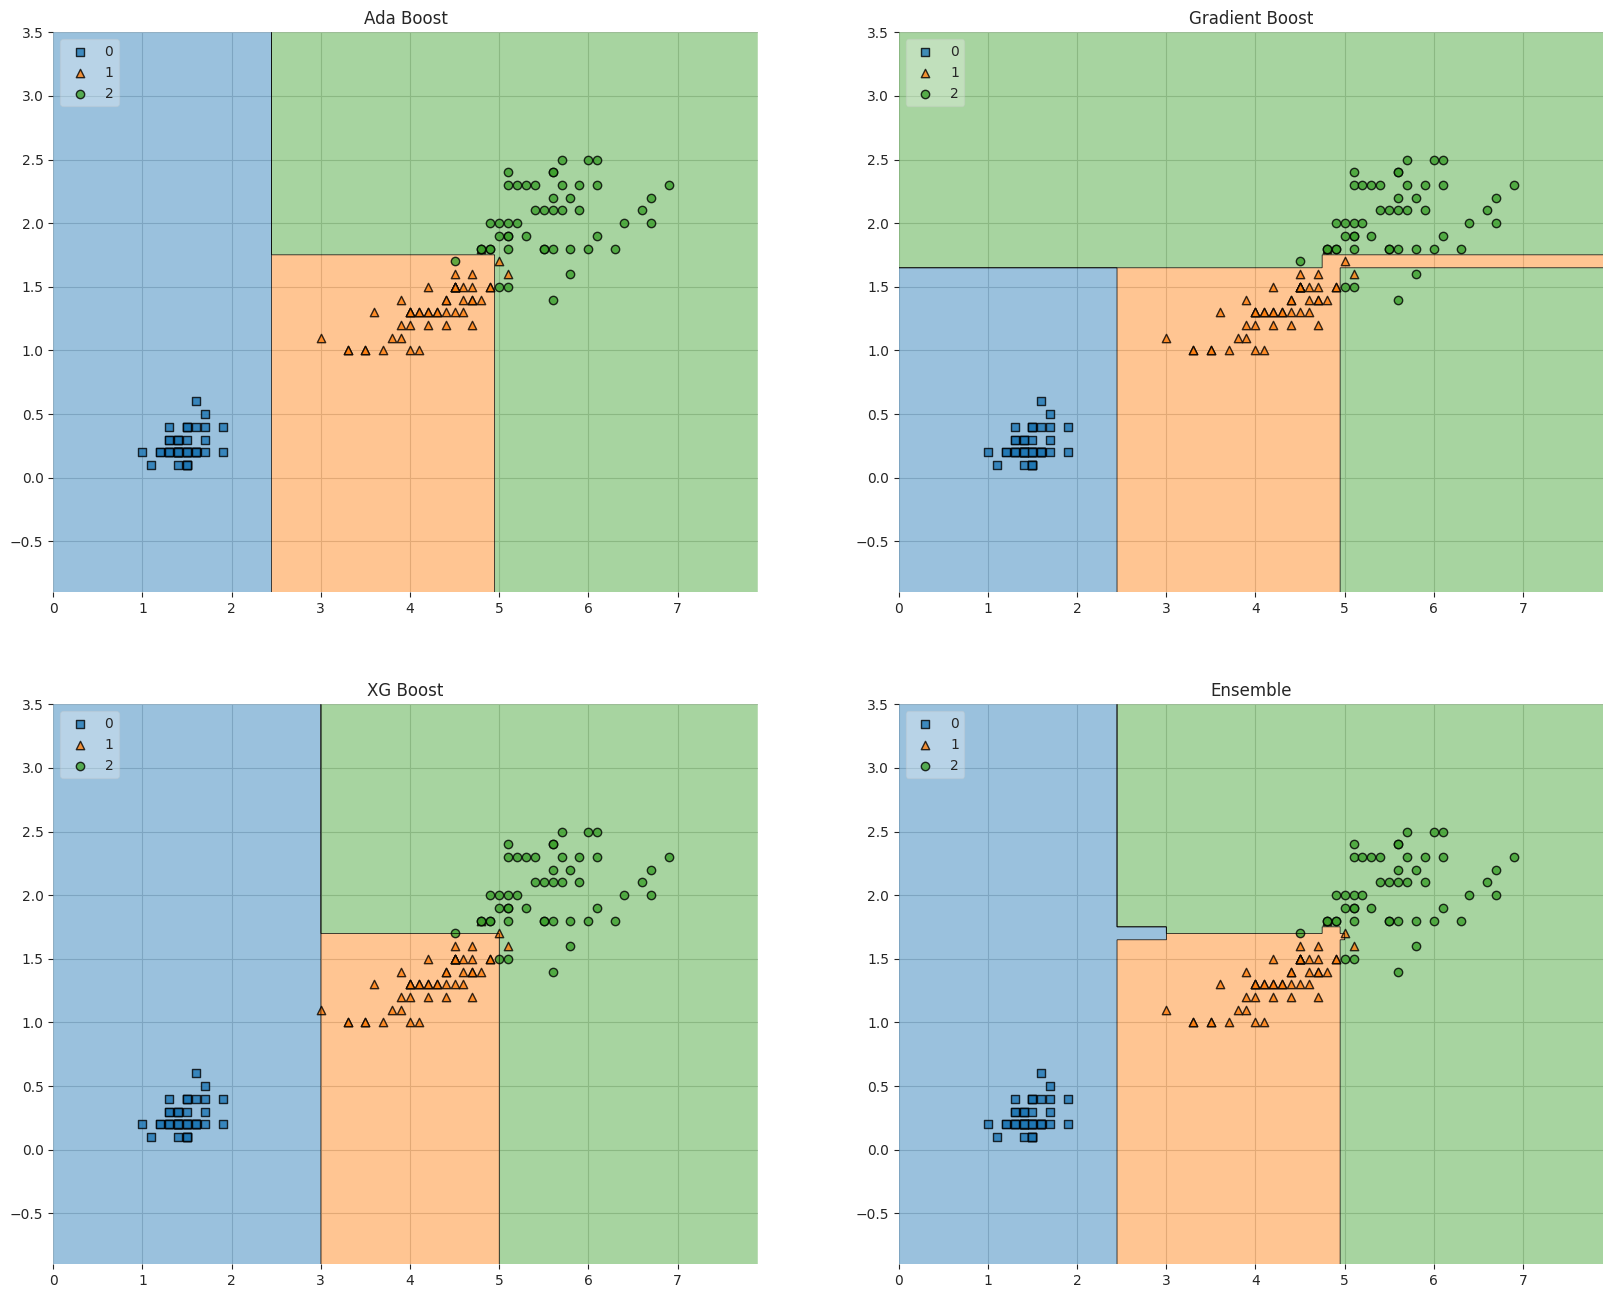

In [9]:
#Decision Regions for all the boosting algorithms.
X = np.array(iris_dataset[['petal_length','petal_width']])
y = np.array(y)

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,16))

for clf, label, grd in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], boosting_labels, itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

### Stacking.

<font color='blue'>Stacking</font> is an ensemble learning technique which is used to <font color='blue'>combine the predictions</font> of diverse <font color='blue'>classification models</font> into one <font color='blue'>single model</font> also known as the <font color='blue'>meta-classifier</font>. All the <font color='blue'>individual models</font> are <font color='blue'>trained separately</font> on the complete training data set and <font color='blue'>fine-tuned</font> to achieve a <font color='blue'>greater accuracy</font>. The bias and variance trade-off is taken care off for each model. The final model, also known as the meta-classifier is fed either the <font color='blue'>class labels</font> predicted by the base models or the <font color='blue'>predicted probabilities</font> for each class label. The meta-classifier is then <font color='blue'>trained</font> based on the<font color='blue'>outputs</font> given by the <font color='blue'>ensemble models</font>. In <font color='blue'>stacking</font>, a <font color='blue'>new model</font> is <font color='blue'>trained</font> based on the <font color='blue'>predictions</font> made by the <font color='blue'>previous models</font>. This process takes place <font color='blue'>sequentially</font>. This means <font color='blue'>several models</font> are <font color='blue'>trained</font> at stage 1 and are <font color='blue'>fine-tuned</font>. The predicted probabilities of each model from stage 1 are fed as an input to all the models at stage 2. The models at stage 2 are then fine-tuned and the corresponding outputs are fed to models at stage 3 and so on. This process occurs multiple times based on how many layers of stacking one would like to use. The <font color='blue'>final stage</font> consists of <font color='blue'>one single powerful model</font>, which gives us the final output by <font color='blue'>combining the output</font> of <font color='blue'>all</font> the <font color='blue'>models present</font> in the <font color='blue'>previous layers</font>. This single powerful model at the end of a stacking pipeline is called the meta-classifier. Often times, using stacking classifiers increases the prediction accuracy of a model. But in no way can there be a guarantee that using stacking will increase the prediction accuracy at all times. Take a look at the below diagrams to understand how stacking works. You can refer to the MLEXTEND Github page at this link: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/, to get more ideas on how to implement stacking in different scenarios.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*BBnMT33PVrMwaTqhsIOupQ.png)

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LASyreyHGaUPKgTVvRIfZA.jpeg)

In code sample below, we will use <font color='blue'>eight different base learners</font> and train each of them on the <font color='blue'>whole dataset</font>. Each of these models can be <font color='blue'>fine-tuned</font> using <font color='blue'>grid search</font> cross-validation. Each of these <font color='blue'>$N$ models</font> will predict <font color='blue'>eight class labels</font>. At the <font color='blue'>final stage</font>, the predictions of all the base models are combined using <font color='blue'>majority voting</font> (for <font color='blue'>classification tasks</font>), to create a final model called the <font color='blue'>meta-classifier</font>. The meta-classifier in our case is the <font color='blue'>logistic regression model</font>. As we can see from the outputs below, stacking has indeed managed to <font color='blue'>increase</font> the <font color='blue'>accuracy</font> of the <font color='blue'>final model</font>. Similar to the previous examples, we will use 3 fold cross-validation. As before, one can experiment with this value in real-world datasets. Further down, in a separate example, we will try grid search cross-validation on the base learners and see if the overall accuracy increases.

In [10]:
RANDOM_SEED = 0

X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
rg_clf = RidgeClassifier(alpha=0.1, random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=RANDOM_SEED)
adab_clf = AdaBoostClassifier(n_estimators=100)
lr = LogisticRegression(random_state=RANDOM_SEED) # meta classifier

sclf = StackingClassifier(classifiers=[rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf], meta_classifier=lr)

classifier_array = [rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf, sclf]
labels = [clf.__class__.__name__ for clf in classifier_array]

acc_list = []
var_list = []

for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))
    acc_list.append(np.round(cv_scores.mean(),4))
    var_list.append(np.round(cv_scores.std(),4))
    #print("Accuracy: {} (+/- {}) [{}]".format(np.round(scores.mean(),4), np.round(scores.std(),4), label))

Accuracy: 0.9667 (+/- 0.0189) [RandomForestClassifier]
Accuracy: 0.9533 (+/- 0.0094) [ExtraTreesClassifier]
Accuracy: 0.9467 (+/- 0.0094) [KNeighborsClassifier]
Accuracy: 0.9600 (+/- 0.0163) [SVC]
Accuracy: 0.7933 (+/- 0.0340) [RidgeClassifier]
Accuracy: 0.9733 (+/- 0.0189) [LogisticRegression]
Accuracy: 0.9333 (+/- 0.0189) [DecisionTreeClassifier]
Accuracy: 0.9600 (+/- 0.0163) [AdaBoostClassifier]
Accuracy: 0.9600 (+/- 0.0163) [StackingClassifier]


### A bar graph to see stacking actually increases the accuracy.

The code block below will <font color='blue'>plot</font> the <font color='blue'>accuracy values</font> for each of the <font color='blue'>base learners</font> and also the <font color='blue'>accuracy</font> of the <font color='blue'>final meta-classifier</font>. We have managed to increase the accuracy value from 0.9600 (highest accuracy obtained from a single base learner) to 0.9608 (using the stacking classifier).

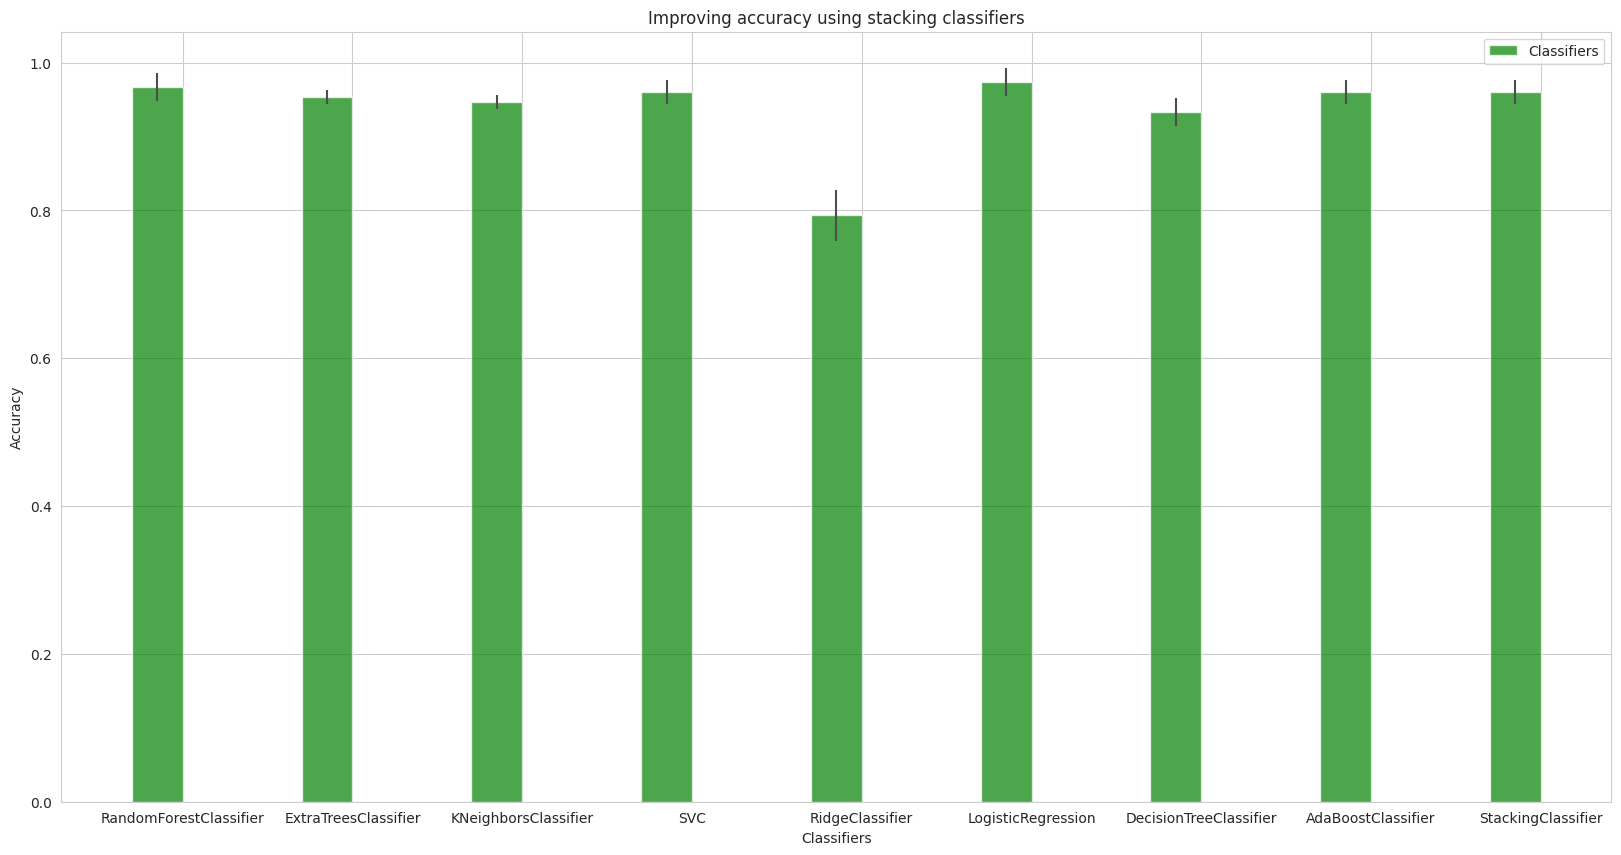

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 9
index = np.arange(n_groups)
bar_width = 0.30

opacity = .7
error_config = {'ecolor': '0.3'}

normal_clf = ax.bar(index, acc_list, bar_width, alpha=opacity, color='g', yerr=var_list, error_kw=error_config, label='Classifiers')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_title('Improving accuracy using stacking classifiers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()
plt.show()

For simplicity, we will look at the <font color='blue'>decision regions</font> obtained using <font color='blue'>three</font> of our <font color='blue'>base learners</font> and also the <font color='blue'>final stacked meta-classifier</font>. The three base learners that we will select for this purpose are <font color='blue'>RandomForestClassifier, SupportVectorClassifer, and RidgeClassifier</font>. As  before, I we train and fit the model to two of the most important features, i.e. <font color='blue'>petal_length</font> and <font color='blue'>petal_width</font>.

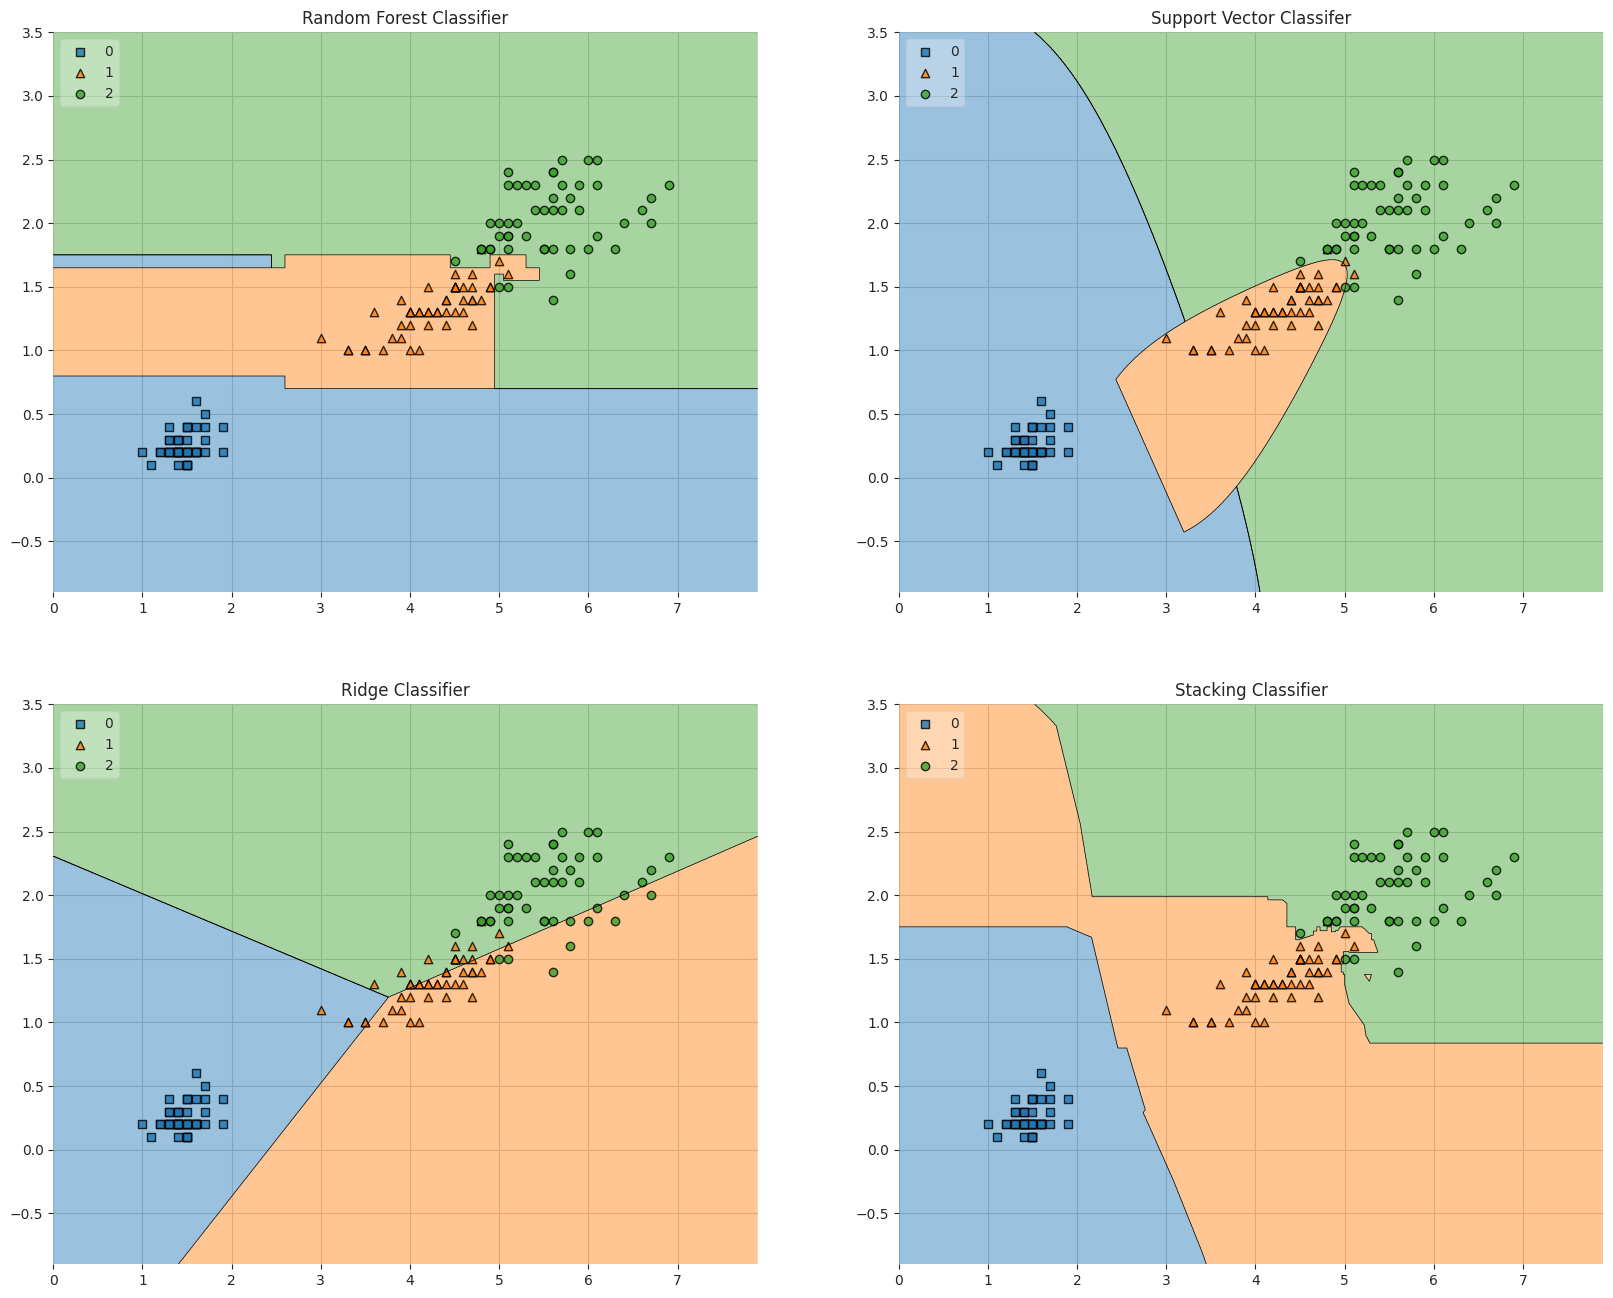

In [12]:
#Decision Regions for 4 algorithms.
X = np.array(iris_dataset[['petal_length','petal_width']])
y = np.array(y)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,16))


for clf, label, grd in zip([rf_clf, svc_clf, rg_clf, sclf], ["Random Forest Classifier", "Support Vector Classifer", "Ridge Classifier", "Stacking Classifier"], itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

Instead of using the <font color='blue'>actual class label</font> of the <font color='blue'>base learners</font>, we can also use the <font color='blue'>probability scores</font> of each of the base models to <font color='blue'>train</font> the <font color='blue'>meta-classifier</font>. For this, we need to set `use_probas=True`. Using `average_probas=True` the <font color='blue'>probability scores</font> of each of the base learners are <font color='blue'>averaged</font>. However, setting `average_probas=False` means that the probability scores for each of the base learners are <font color='blue'>stacked</font> and they are all <font color='blue'>passed as input</font> to the <font color='blue'>next level classifiers</font>. Note, that we have actually managed to <font color='blue'>increase the accuracy</font> of the <font color='blue'>stacking classifiers</font> by using <font color='blue'>probability score</font>. 0.9673 as compared to 0.9608, as shown in the example below.

In [13]:
RANDOM_SEED = 0
from sklearn.naive_bayes import GaussianNB

X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=RANDOM_SEED)
adab_clf = AdaBoostClassifier(n_estimators=100)
lr = LogisticRegression(random_state=RANDOM_SEED) # meta classifier
gnb_clf = GaussianNB()

#sclf = StackingClassifier(classifiers=[rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf], use_probas=True, average_probas=False, meta_classifier=lr)
sclf = StackingClassifier(classifiers=[rf_clf, knn_clf, gnb_clf, lr_clf, et_clf, dt_clf, adab_clf], use_probas=True, average_probas=False, meta_classifier=lr)

classifier_array = [rf_clf, knn_clf, gnb_clf, lr_clf, et_clf, dt_clf, adab_clf, sclf]
labels = [clf.__class__.__name__ for clf in classifier_array]

for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))

Accuracy: 0.9667 (+/- 0.0189) [RandomForestClassifier]
Accuracy: 0.9467 (+/- 0.0094) [KNeighborsClassifier]
Accuracy: 0.9400 (+/- 0.0163) [GaussianNB]
Accuracy: 0.9733 (+/- 0.0189) [LogisticRegression]
Accuracy: 0.9533 (+/- 0.0094) [ExtraTreesClassifier]
Accuracy: 0.9333 (+/- 0.0189) [DecisionTreeClassifier]
Accuracy: 0.9600 (+/- 0.0163) [AdaBoostClassifier]
Accuracy: 0.9600 (+/- 0.0163) [StackingClassifier]


Now let us <font color='blue'>implement stacking</font> using <font color='blue'>Grid Search cross-validation</font> to <font color='blue'>fine tune</font> the base learners. For simplicity, we will use three base learners and one final meta-classifier. Needless to say, you can use as many models as you want as long as you know how the implementation works and what the specific hyperparameters are for each base learners. Please note that we have used the same set of classifiers as shown in the first example of stacking. This time with Grid Search cross-validation. Let's find out if the accuracy increases.

In [14]:
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 0

X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)


#Base Learners.
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED,n_jobs=-1)
knn_clf = KNeighborsClassifier(p=2, metric='minkowski',n_jobs=-1)
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=RANDOM_SEED)
lr = LogisticRegression(random_state=RANDOM_SEED) # meta classifier

#sclf = StackingClassifier(classifiers=[rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf], meta_classifier=lr)
sclf = StackingClassifier(classifiers=[rf_clf, knn_clf, dt_clf], meta_classifier=lr)

print("\nAccuracies of all classifiers using grid search cross validation.")

params = {
    'randomforestclassifier__n_estimators': np.arange(10, 15),
    'randomforestclassifier__max_depth': np.arange(1, 5),
    'kneighborsclassifier__n_neighbors': np.arange(1, 10, 2),
    'decisiontreeclassifier__max_depth': np.arange(1, 5),
    'meta_classifier__C': [0.001, 0.1, 10, 1000]
}


gsearch_cv = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
gsearch_cv.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

print('Best parameters: %s' % gsearch_cv.best_params_)
print('Accuracy: %.2f' % gsearch_cv.best_score_)


Accuracies of all classifiers using grid search cross validation.
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'kneighborsclassifier__n_neighbors': 7, 'meta_classifier__C': 0.1, 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 11}
Accuracy: 0.98


### Decision boundaries of the above stacking classifiers using the best hyperparameter values.

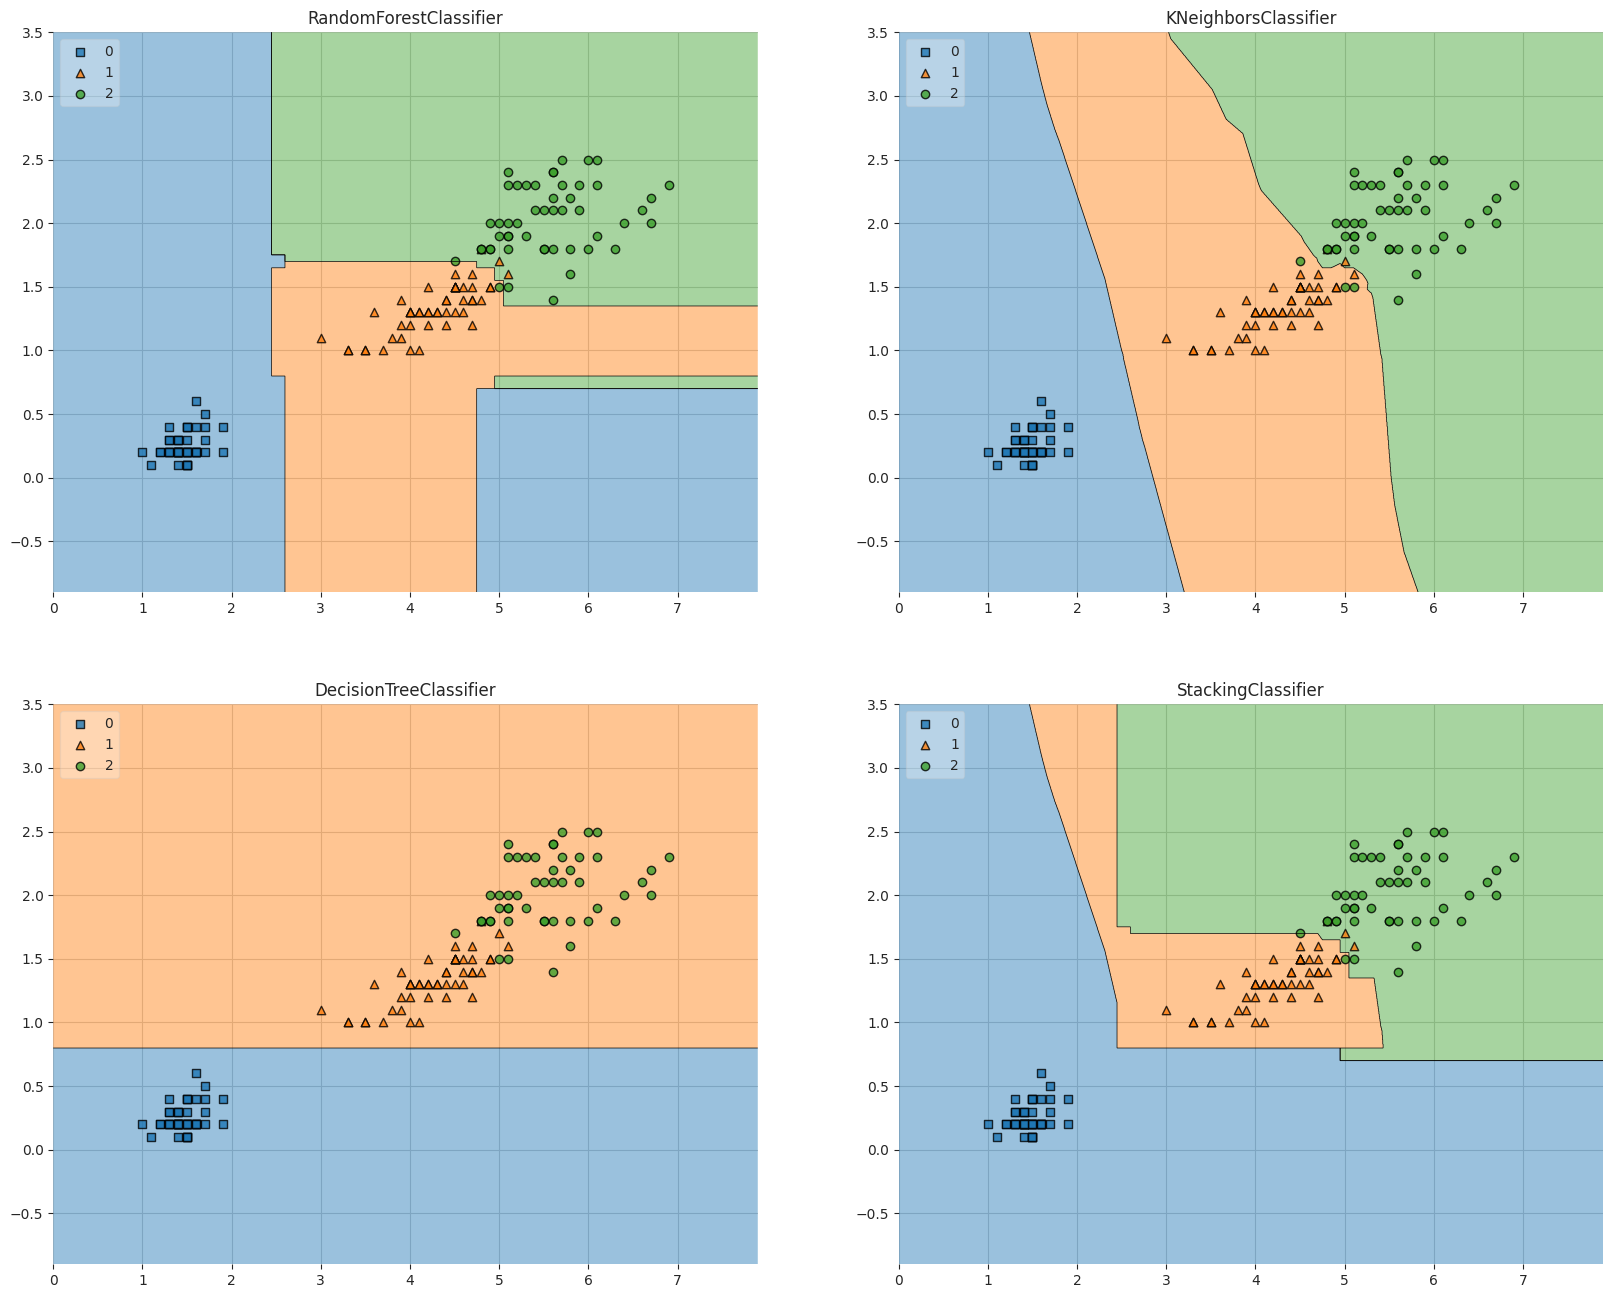

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

#Decision Regions for 4 algorithms.
X = np.array(iris_dataset[['petal_length','petal_width']])
y = np.array(y)

#Base Learners.
rf_clf = RandomForestClassifier(max_depth=3,n_estimators=15,random_state=RANDOM_SEED,n_jobs=-1)
knn_clf = KNeighborsClassifier(n_neighbors=7,p=2, metric='minkowski',n_jobs=-1)
dt_clf = DecisionTreeClassifier(max_depth=1,criterion='gini', random_state=RANDOM_SEED)
lr = LogisticRegression(C=0.1,random_state=RANDOM_SEED) # meta classifier
sclf = StackingClassifier(classifiers=[rf_clf, knn_clf, dt_clf], meta_classifier=lr)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,16))


for clf, label, grd in zip([rf_clf, knn_clf, dt_clf, sclf], ["RandomForestClassifier", "KNeighborsClassifier", "DecisionTreeClassifier", "StackingClassifier"], itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()



### Multi-Level stacking.

The examples we have covered for Stacking classifiers are all <font color='blue'>ensemble models</font> with <font color='blue'>one single level</font>. But in general <font color='blue'>multiple models</font> can be stacked across <font color='blue'>multiple levels</font>. We will dsiplay one such Stacking design used by the winners of the <font color='blue'>Kaggle KDD cup competition</font>. This image was uploaded in a PPT designed by the SAS team, by author Jeong-Yoon Lee. You can check this wonderful video in Youtube at this link:https://www.youtube.com/watch?v=9IyJ4HvubGo&t=1070s, for further elaborations.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*psoOqpYfX3yRJ2aqTzWxcw.png)

The above stacking model uses <font color='blue'>64 base learners</font> on <font color='blue'>seven feature sets</font> at <font color='blue'>level 1</font>. All the 64 models are <font color='blue'>trained independently</font> on the training set. The predictions of these 64 models are <font color='blue'>fed to</font> Stage 1 <font color='blue'>ensemble classifiers</font> which have <font color='blue'>15 more models</font>. The predictions of these 15 models are <font color='blue'>further combined</font> using <font color='blue'>majority vote</font> and their output is <font color='blue'>fed</font> to Stage 2 <font color='blue'>ensemble classifiers</font>, which has <font color='blue'>2 models</font>. Finally, the <font color='blue'>output</font> of these <font color='blue'>2 models</font> are <font color='blue'>fed</font> to the <font color='blue'>meta-classifier</font> in Stage 3, which gives us the final output of the model.



### Cascading classifiers

<font color='blue'>Cascading</font>, according to Google, in simple English literature means <font color='blue'>a process whereby something, typically information or knowledge, is successively passed on</font>. Cascading is one of the <font color='blue'>most powerful ensemble learning algorithm</font> which is used by Machine Learning engineers and scientists when they want to be <font color='blue'>absolutely dead sure about</font> the <font color='blue'>accuracy</font> of a result. For example, suppose we want to build a machine learning model which would detect if a <font color='blue'>credit card transaction</font> is <font color='blue'>fraudulent</font> or not. If you think about it, it's a <font color='blue'>binary classification problem</font> where a class <font color='blue'>label 0</font> means the transaction is <font color='blue'>not fraud</font> & a class <font color='blue'>label 1</font> means the transaction is <font color='blue'>fraudulent</font>. In such a model, it's very risky to put our faith completely on just one model. So what we do is <font color='blue'>build a sequence of models</font> (or a cascade of models) to be absolutely sure about the fact that the transaction is not fraudulent. Cascade models are mostly used when the <font color='blue'>cost of making a mistake</font> is <font color='blue'>very high</font>. We will help explain cascading through a diagram.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*5RMlhv9U_gPNTnamEwY-uQ.jpeg)

Look at the above diagram. Given that we have a <font color='blue'>transaction query point $X_q$</font>, we will <font color='blue'>feed it to Model 1</font>. Model 1 can be <font color='blue'>anything</font> - a <font color='blue'>random forest</font>, or a <font color='blue'>logistic regression</font> model or maybe a <font color='blue'>support vector machine</font>. Basically what Model 1 does is that it <font color='blue'>predicts class probabilities</font> to <font color='blue'>determine</font> to <font color='blue'>which class</font> do a <font color='blue'>given query point</font> has <font color='blue'>higher chances</font> of <font color='blue'>belonging</font> to. Let's say class <font color='blue'>label 1</font> means the <font color='blue'>transaction</font> is <font color='blue'>fraudulent</font>, and class <font color='blue'>label 0</font> means the transaction is <font color='blue'>not fraud</font>. Typically, the predicted probabilities is given by this -

$$P(Y_q=0) \text{ and } P(Y_q=1)$$

where <font color='blue'>$Y_q$</font> is our <font color='blue'>actual class label</font>. Now let's <font color='blue'>assume</font> that <font color='blue'>$P(Y_q=0)$</font>, i.e. the probability of the transaction to be not fraudulent is <font color='blue'>very high</font>. If you think carefully, if $P(Y_q=0)$ is extremely high, we will say that the transaction is not fraud. Let's assume we have set a <font color='blue'>threshold</font> of <font color='blue'>99%</font>. It means if and only if

$$P(Y_q=0) > 0.99,$$

 we will declare the <font color='blue'>final prediction</font> to be <font color='blue'>not fraudulent</font>. However, if

 $$P(Y_q=0) < 0.99$$

 we are <font color='blue'>not sure</font> if or not it's a fraudulent transaction although though there is a high chance that the transaction is not fraudulent. In such a case, when $P(Y_q=0) < 0.99$, we want to be really sure that the transaction is not fraudulent. We need to be <font color='blue'>absolutely careful</font> because if our <font color='blue'>model fails to detect</font> a <font color='blue'>fraudulent transaction</font> we might <font color='blue'>lose millions of dollars</font>! So even when we are <font color='blue'>slightly unsure</font>, we will train <font color='blue'>another Model 2</font>. Model 2 does the <font color='blue'>same thing</font>, it <font color='blue'>receives</font> the <font color='blue'>query point</font> and <font color='blue'>predicts $P(Y_q=0)$</font>. Just like in stage 1, if

 $$P(Y_q=0) > 0.99,$$

 we will <font color='blue'>declare</font> the transaction to be <font color='blue'>not fraudulent</font> and terminate the loop. But <font color='blue'>again</font> if we get $P(Y_q=0) < 0.99$, we aren't sure. Hence, we will <font color='blue'>pass</font> the <font color='blue'>query point</font> to another <font color='blue'>Model 3</font> in the <font color='blue'>cascade</font> which <font color='blue'>does the same thing</font>. In a typical cascading system the <font color='blue'>complexity</font> of <font color='blue'>models increases</font> as we <font color='blue'>add more and more models</font> to the cascade.  Please note that all the models in a cascade are super powerful and have a very high accuracy on unseen data. However, it <font color='blue'>might happen</font> that <font color='blue'>none</font> of the models can <font color='blue'>give us</font> a <font color='blue'>value</font> of $P(Y_q=0) > 0.99$. In such a case, typically there is a human being who sits at the end of a cascade. This person will personally call the customer and ask him whether or not he has done the transaction. Now, we are absolutely certain that the transaction is not a fraud one when the customer says that he is the one who has done the transaction.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*kha0EIOSOVstLK1u2XRSNQ.jpeg)

The above diagram shows us the <font color='blue'>different stages</font> of <font color='blue'>training</font> in a <font color='blue'>cascade system of classifiers</font>. Here we have <font color='blue'>four models</font> in a <font color='blue'>sequence</font>. We will train <font color='blue'>model 1</font> on the <font color='blue'>whole training dataset</font> and evaluate its performance on the test dataset. Now wherever we are sure that the <font color='blue'>class label</font> is <font color='blue'>0</font>, we will categorize <font color='blue'>all such points</font> in a dataset <font color='blue'>D'</font>. This is at stage 1 of the training phase. Thus D' contains <font color='blue'>all such data points</font> for which the class label is <font color='blue'>0</font>, i.e. the transaction is <font color='blue'>not fraudulent</font>. Now, wherever we are <font color='blue'>not sure</font> about <font color='blue'>some data points</font> (if they are fraudulent or not) we pass it to the <font color='blue'>next stage</font> i.e. <font color='blue'>Model 2</font> in our case. Hence, <font color='blue'>model 2</font> will <font color='blue'>only train</font> on the <font color='blue'>dataset</font> which <font color='blue'>does not contain points from D'</font>. Model 2 can't be exposed to all such points for which we are sure that the class label is 0. It will <font color='blue'>only train on the points</font> for which we are <font color='blue'>not sure</font>. After this, we will put <font color='blue'>all such points</font> in a dataset <font color='blue'>D''</font> for which we <font color='blue'>are sure</font> that they belong to <font color='blue'>class label 0</font> at the end of stage 2. We will <font color='blue'>repeat the same procedure</font> for stage 3 as well unless the training phase reaches the final model. Intuitively, if you think about it, the cascades are designed in such a way that the <font color='blue'>next model in the sequence</font> is only <font color='blue'>trained</font> on the <font color='blue'>data points</font> for which the <font color='blue'>model isn't sure</font> what the <font color='blue'>class label is</font>. We must always train our model as per what type of data it would see during runtime.

This gives an intuition of how cascading in machine learning works For the above explanations on cascading, we have referred to Mr. Varma's teachings from AAIC. We have not provided any code samples for cascading classifiers as we didn't implement it.

There is a very interesting paper on cascading models written by few Ph.D. folks at Stanford University. These guys have actually <font color='blue'>built a framework called Cascaded Classification Models (CCM)</font>, which aims at <font color='blue'>improving the accuracy/performance</font> at <font color='blue'>each level</font> by <font color='blue'>repeatedly instantiating</font> the <font color='blue'>classifiers</font> coupled by their <font color='blue'>input/output variables</font> in a cascade. You can read more about the paper at this link: https://ai.stanford.edu/~koller/Papers/Heitz+al:NIPS08a.pdf

There is also a very <font color='blue'>interesting blog</font> on how to <font color='blue'>build a face detection model</font> using cascade classifiers. If you are interested you can visit http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_face_detection.html to see how it works!

## Closing Remarks

In general, ensemble learnings are mostly used by <font color='blue'>Kaggle participants</font> to <font color='blue'>fine-tune</font> their <font color='blue'>models</font>. In industries however, <font color='blue'>stacking huge models</font> in several levels is a <font color='blue'>very costly procedure</font>. And a 0.5% increase in accuracy practically won't have the greatest of impact on business problems. However, for Kaggle competetions ensemble techniques are state of the art strategies that can be used to increase the accuracy by maybe 0.001, which might just help you win the competition!

Here are few solid recommendations as part of some additional readings on ensemble learning algorithms:

1. The diagrams are drawn using an awesome tool provdided by this website: https://www.draw.io/. You can use this tool to draw anything you like and it's as simple as drawing using your crayons!
2. I would recommend you guys to read through each and every examples given by the MLEXTEND GitHub page at: http://rasbt.github.io/mlxtend/.  
3. For additional details about ensemble techniques please read this nice blog written by Dr. Robi Polikar of Rowan University at this link: http://www.scholarpedia.org/article/Ensemble_learning
4. You can also visit the Wikipedia page on ensemble learning for further information: https://en.wikipedia.org/wiki/Ensemble_learning
5. Please refer to this blogpost by Vadim Smolyakov: https://blog.statsbot.co/ensemble-learning-d1dcd548e936
6. Also, there is an extremely beautiful series of videos at MIT OpenCourseWare by Dr. Patrick Winston. Check this link: https://www.youtube.com/watch?v=UHBmv7qCey4
7. Read the Kaggle ensemble guide, written by  Vitaly Kuznetsov here: https://mlwave.com/kaggle-ensembling-guide/
8. For sklearn, you can visit https://scikit-learn.org/stable/modules/ensemble.html for more information about the built in packages used for ensemble learning.